# Let's Cluster some Credit Cards!
In this notebook we will try to cluster some credit cards. We will go through preprocessing, choose a model and train it on our data, and then evaluate our outcomes.

The dataset you will use is `Credit Card Dataset.csv`

# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from  sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

# EDA
Explore the Dataset Perform initial exploration of your dataset. Understand the features and the distribution of data.

In [2]:
df = pd.read_csv('Datasets/Credit Card Dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [4]:
df.duplicated().sum()

0

# Preprocessing
1. Remove the outliers
2. Impute missing data
3. Scale the data
4. Reduce dimentions using PCA

In [5]:
df = df.drop('CUST_ID',axis=1)

null_columns = df.columns[df.isna().any()]
for i in null_columns:
    df[i] = df[i].fillna(df[i].mode()[0], inplace=True)
    
def remove_outliers(df,column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound  = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return df.loc[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for i in df.select_dtypes(exclude=['object']).columns:
    df = remove_outliers(df,i)
    
    
le = LabelEncoder()
for i in df.select_dtypes(include=['object']).columns:
    df[i] = le.fit_transform(df[[i]])

ss = StandardScaler()
for i in df.select_dtypes(exclude=['object']).columns:
    print(i)
    df[i] = ss.fit_transform(df[[i]])
    


BALANCE
BALANCE_FREQUENCY
PURCHASES
ONEOFF_PURCHASES
INSTALLMENTS_PURCHASES
CASH_ADVANCE


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PURCHASES_FREQUENCY
ONEOFF_PURCHASES_FREQUENCY
PURCHASES_INSTALLMENTS_FREQUENCY
CASH_ADVANCE_FREQUENCY
CASH_ADVANCE_TRX
PURCHASES_TRX
CREDIT_LIMIT
PAYMENTS
MINIMUM_PAYMENTS
PRC_FULL_PAYMENT
TENURE


#### Dimention Reduction using PCA
K-means, DBSCAN and agglomerative clustering, all use the Euclidean distance, which starts to lose its meaning when the number of dimensions starts increasing. so, before using these methods, we have to reduce the number of dimensions. We are going to use PCA, which is by far the most popular dimensionality reduction algorithm.

Please set the parameter `n_components` equals to 0.9, which means that the PCA will automatically produce enough PCs that will preserve 90% of variance in the dataset.

In [6]:
from sklearn.decomposition import PCA
X = pd.DataFrame(df).to_numpy()
Z = (X - X.mean()) / X.std()
# Let's say, components = 2
pca = PCA(n_components=0.9)
pca_X = pca.fit_transform(Z)

In [7]:
pca_X

array([[-0.37576026, -2.85018306,  0.11527369, ..., -0.31594678,
         1.65444105,  0.44698004],
       [-0.95439014, -1.63099458,  0.67368559, ...,  0.78536615,
        -0.15652565,  0.27303406],
       [ 2.94836796,  0.20154029, -1.95603071, ...,  0.49699942,
         0.35185088, -0.37778907],
       ...,
       [ 3.62315463, -0.38586701, -1.91302587, ..., -0.47776454,
         0.18925478,  0.86597059],
       [ 2.38472255,  0.17262893, -1.79118258, ..., -1.94574834,
        -1.66560749, -0.9919243 ],
       [ 2.17319932,  2.5142394 ,  0.59177888, ..., -1.00700865,
        -0.30816662,  1.86629157]])

# Train the Model
Now that we have done the preprocessing step, we can perform K-means clustering on the data.

* Find the `n_clusters` parameter using the elbow method.
* Train the model.

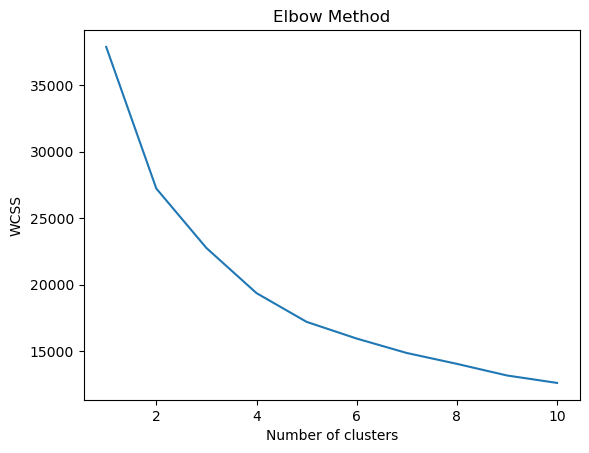

In [8]:
# X = df_pca1 
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pca_X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [40]:
kmeans_model = KMeans(n_clusters=2)
kmeans_model.fit(pca_X)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

# Evaluate the Model

In [41]:
y_kmeans = kmeans_model.predict(pca_X)


In [50]:
from sklearn.metrics import silhouette_score

labels = kmeans_model.labels_

sil_score = silhouette_score(X, labels)

print(wcss[1])


27234.1248445147


# Plot the data points with their predicted cluster center

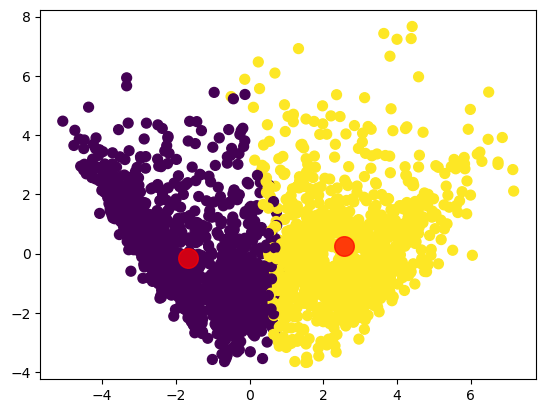

In [43]:
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)  # Mark the centroids
plt.show()